In [1]:
input_dim = 13
num_clusters = 6

model_file = "/home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt"

import csv
import json
import numpy as np
import os
import pandas as pd


import sys
sys.path.insert(0, "../Code/")
from explain_cs import explain
from load_scvis import load_vae
from metrics import metrics, eval_epsilon
from myplot import plot_polys, plot_groups, plot_metrics, plot_explanation
from misc import poly2labels

def load_model(input_dim = input_dim, model_file = model_file):
    return load_vae(input_dim, model_file)


In [2]:
# Load Data & Configuration

x = pd.read_csv("Data/X.tsv", sep="\t").values

y = pd.read_csv("Data/y.tsv", sep="\t").values

with open("vertices.json") as json_file:  
    all_vertices = json.load(json_file)


In [3]:
# Calculate Data Representation

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x, D: np.zeros((1, input_dim))})


INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


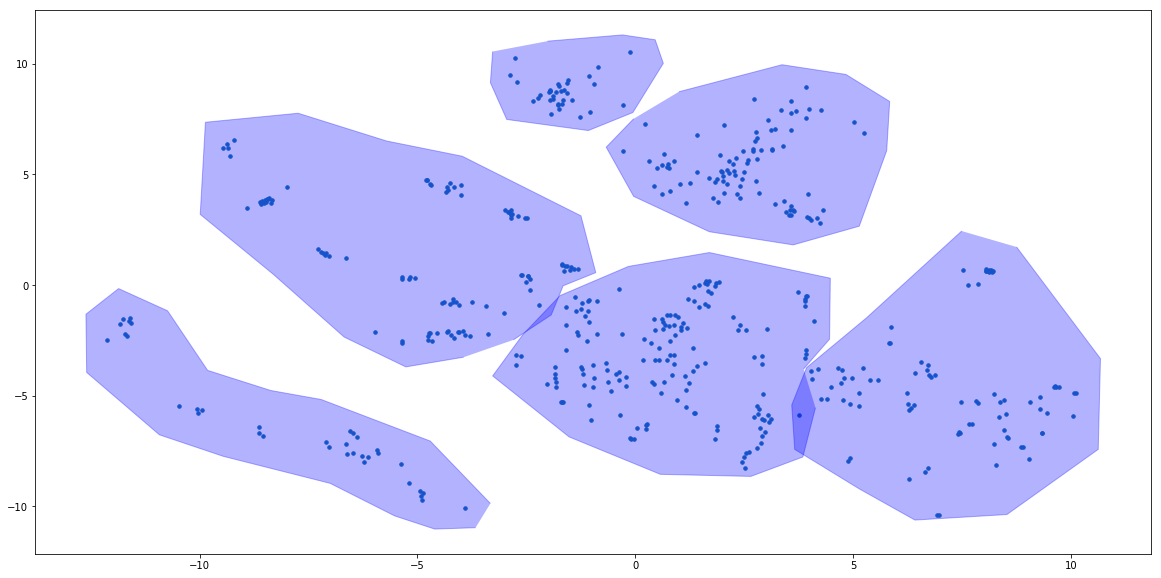

In [4]:
# Visualize the data and the marked clusters

plot_polys(data_rep, all_vertices)


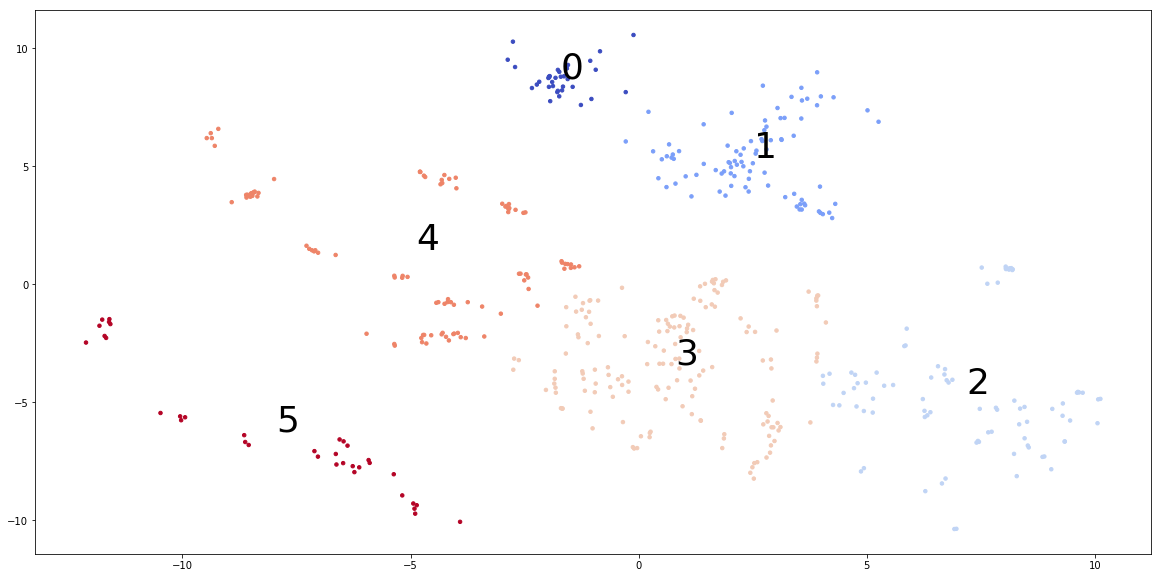

In [5]:
# Visualize the clusters in the learned representation

labels = poly2labels(data_rep, all_vertices)

means, centers, indices = plot_groups(x, data_rep, num_clusters, labels, name = "housing-rep.png")
 

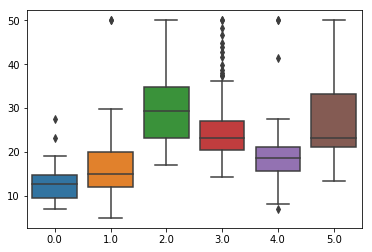

In [6]:
# See what signal is enocded in the clusters

import seaborn as sns

sns_plot = sns.boxplot(x = labels, y = np.squeeze(y))
sns_plot.get_figure().savefig("housing-labels.png")

In [7]:
# Set epsilon for our metrics
epsilon = 1.5

if True:
    eval_epsilon(load_model, x, indices, epsilon)


INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


In [8]:
# Compute the group explanations

best_val = 0.0
for i in range(5):
    deltas = explain(load_model, means, centers, learning_rate = 0.01, consecutive_steps = 5, lambda_global = 3.0)
    a, b = metrics(load_model, x, indices, deltas, epsilon)
    
    val = np.mean(a)
    
    if val > best_val:
        best_val = val
        np.save("deltas.npy", deltas)
    
    os.system("rm -rf explanation")


INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_l

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


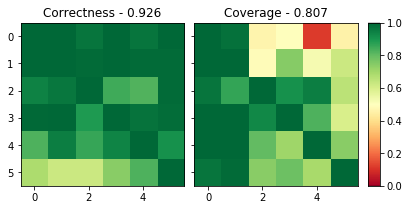

In [9]:
# Evaluate the explanations

deltas = np.load("deltas.npy")

a, b = metrics(load_model, x, indices, deltas, epsilon)

plot_metrics(a, b, name = "housing-metrics.png")

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


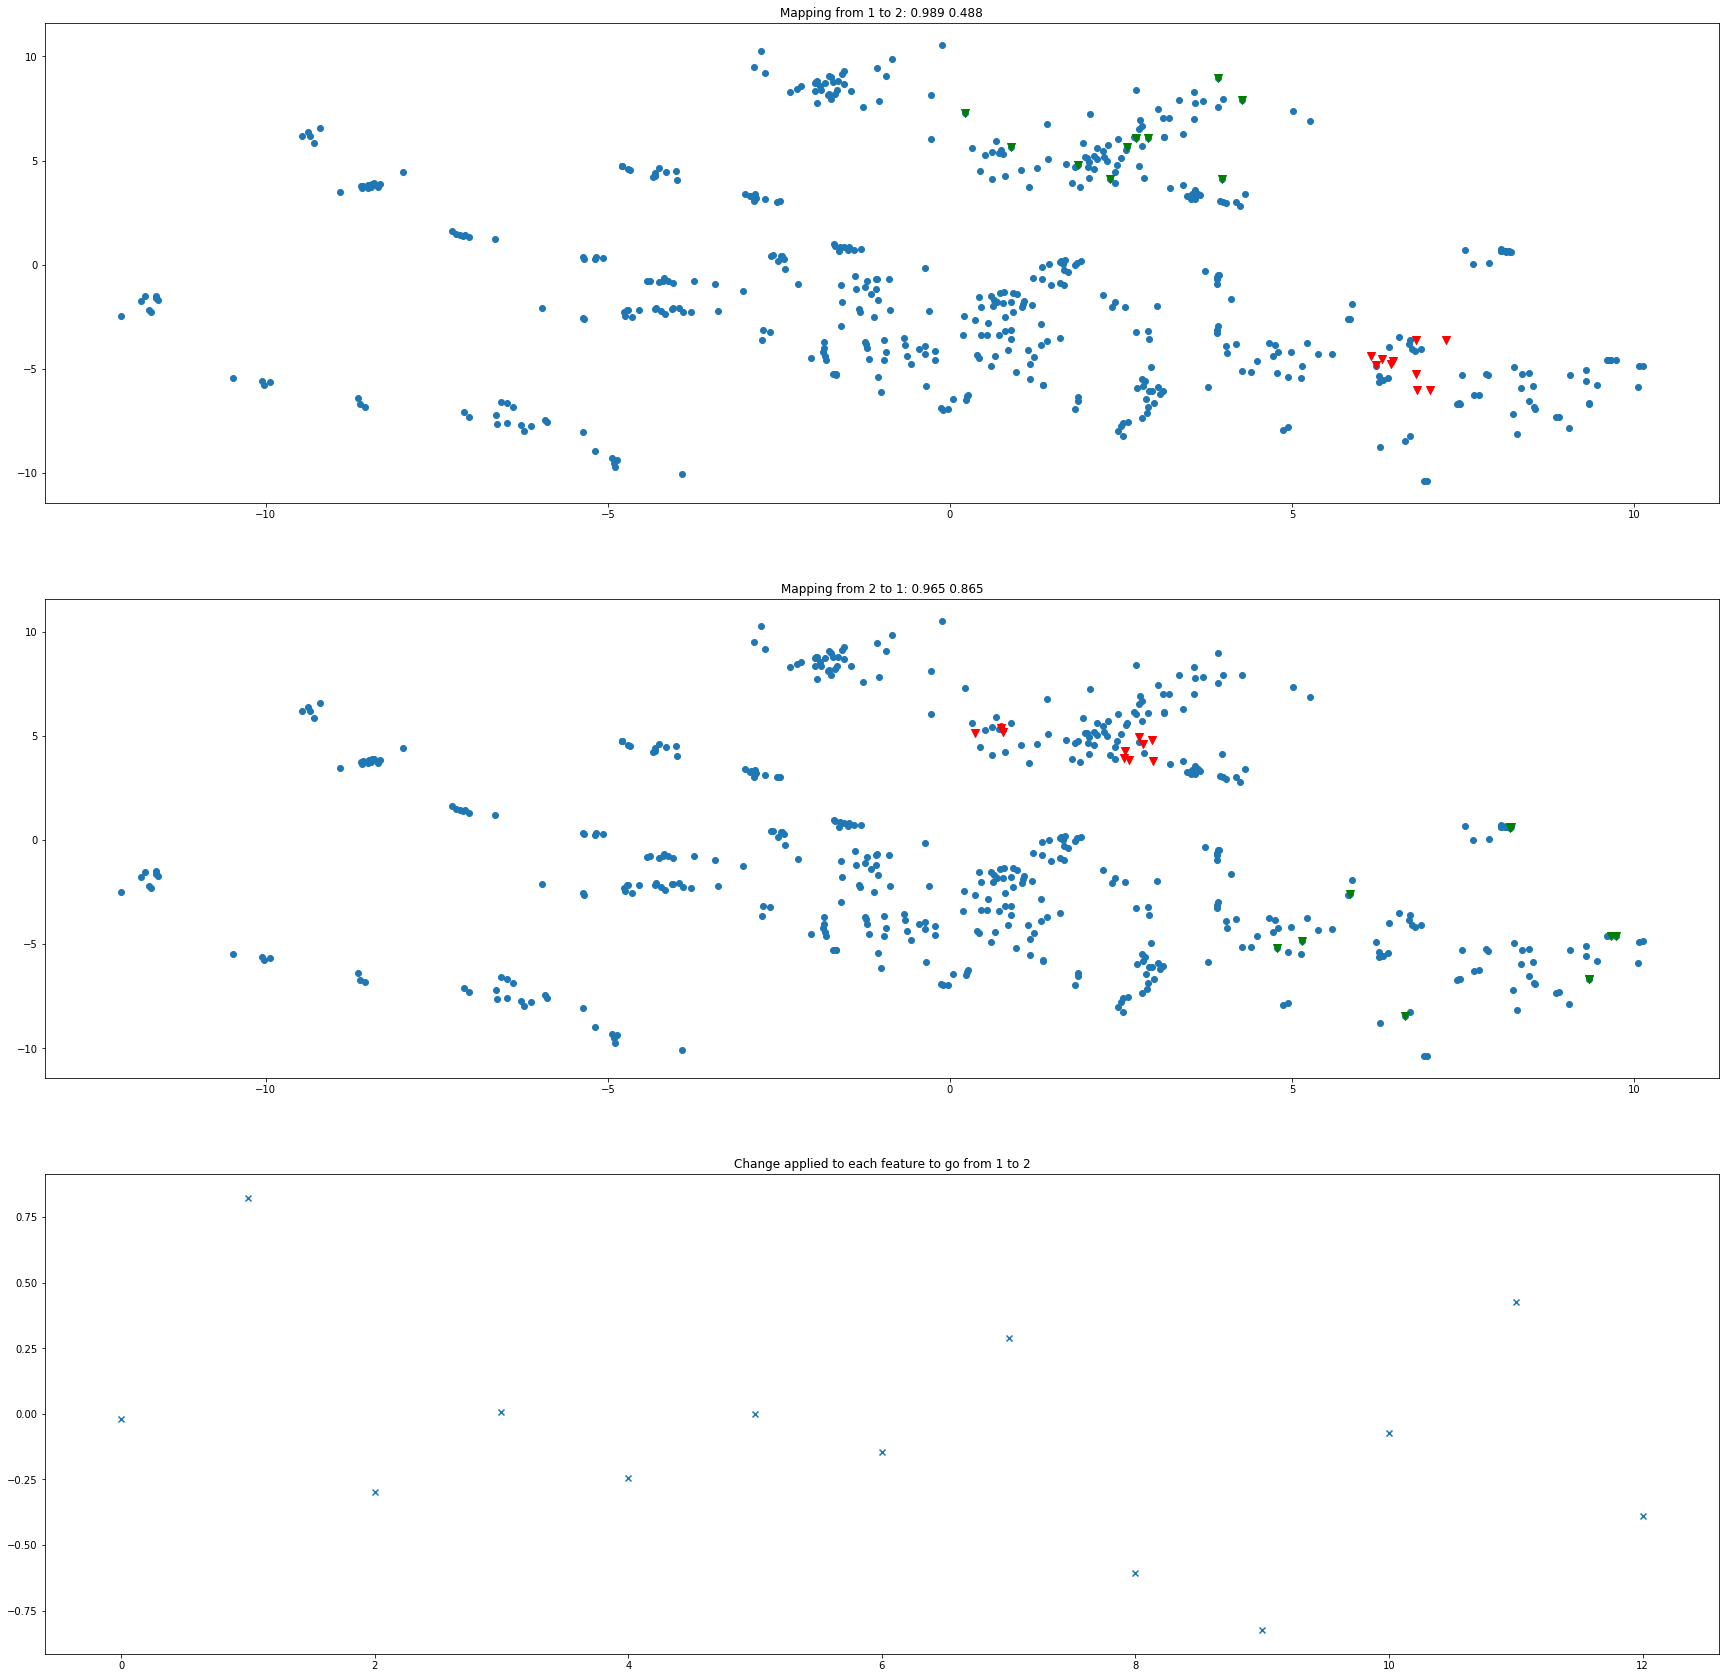

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


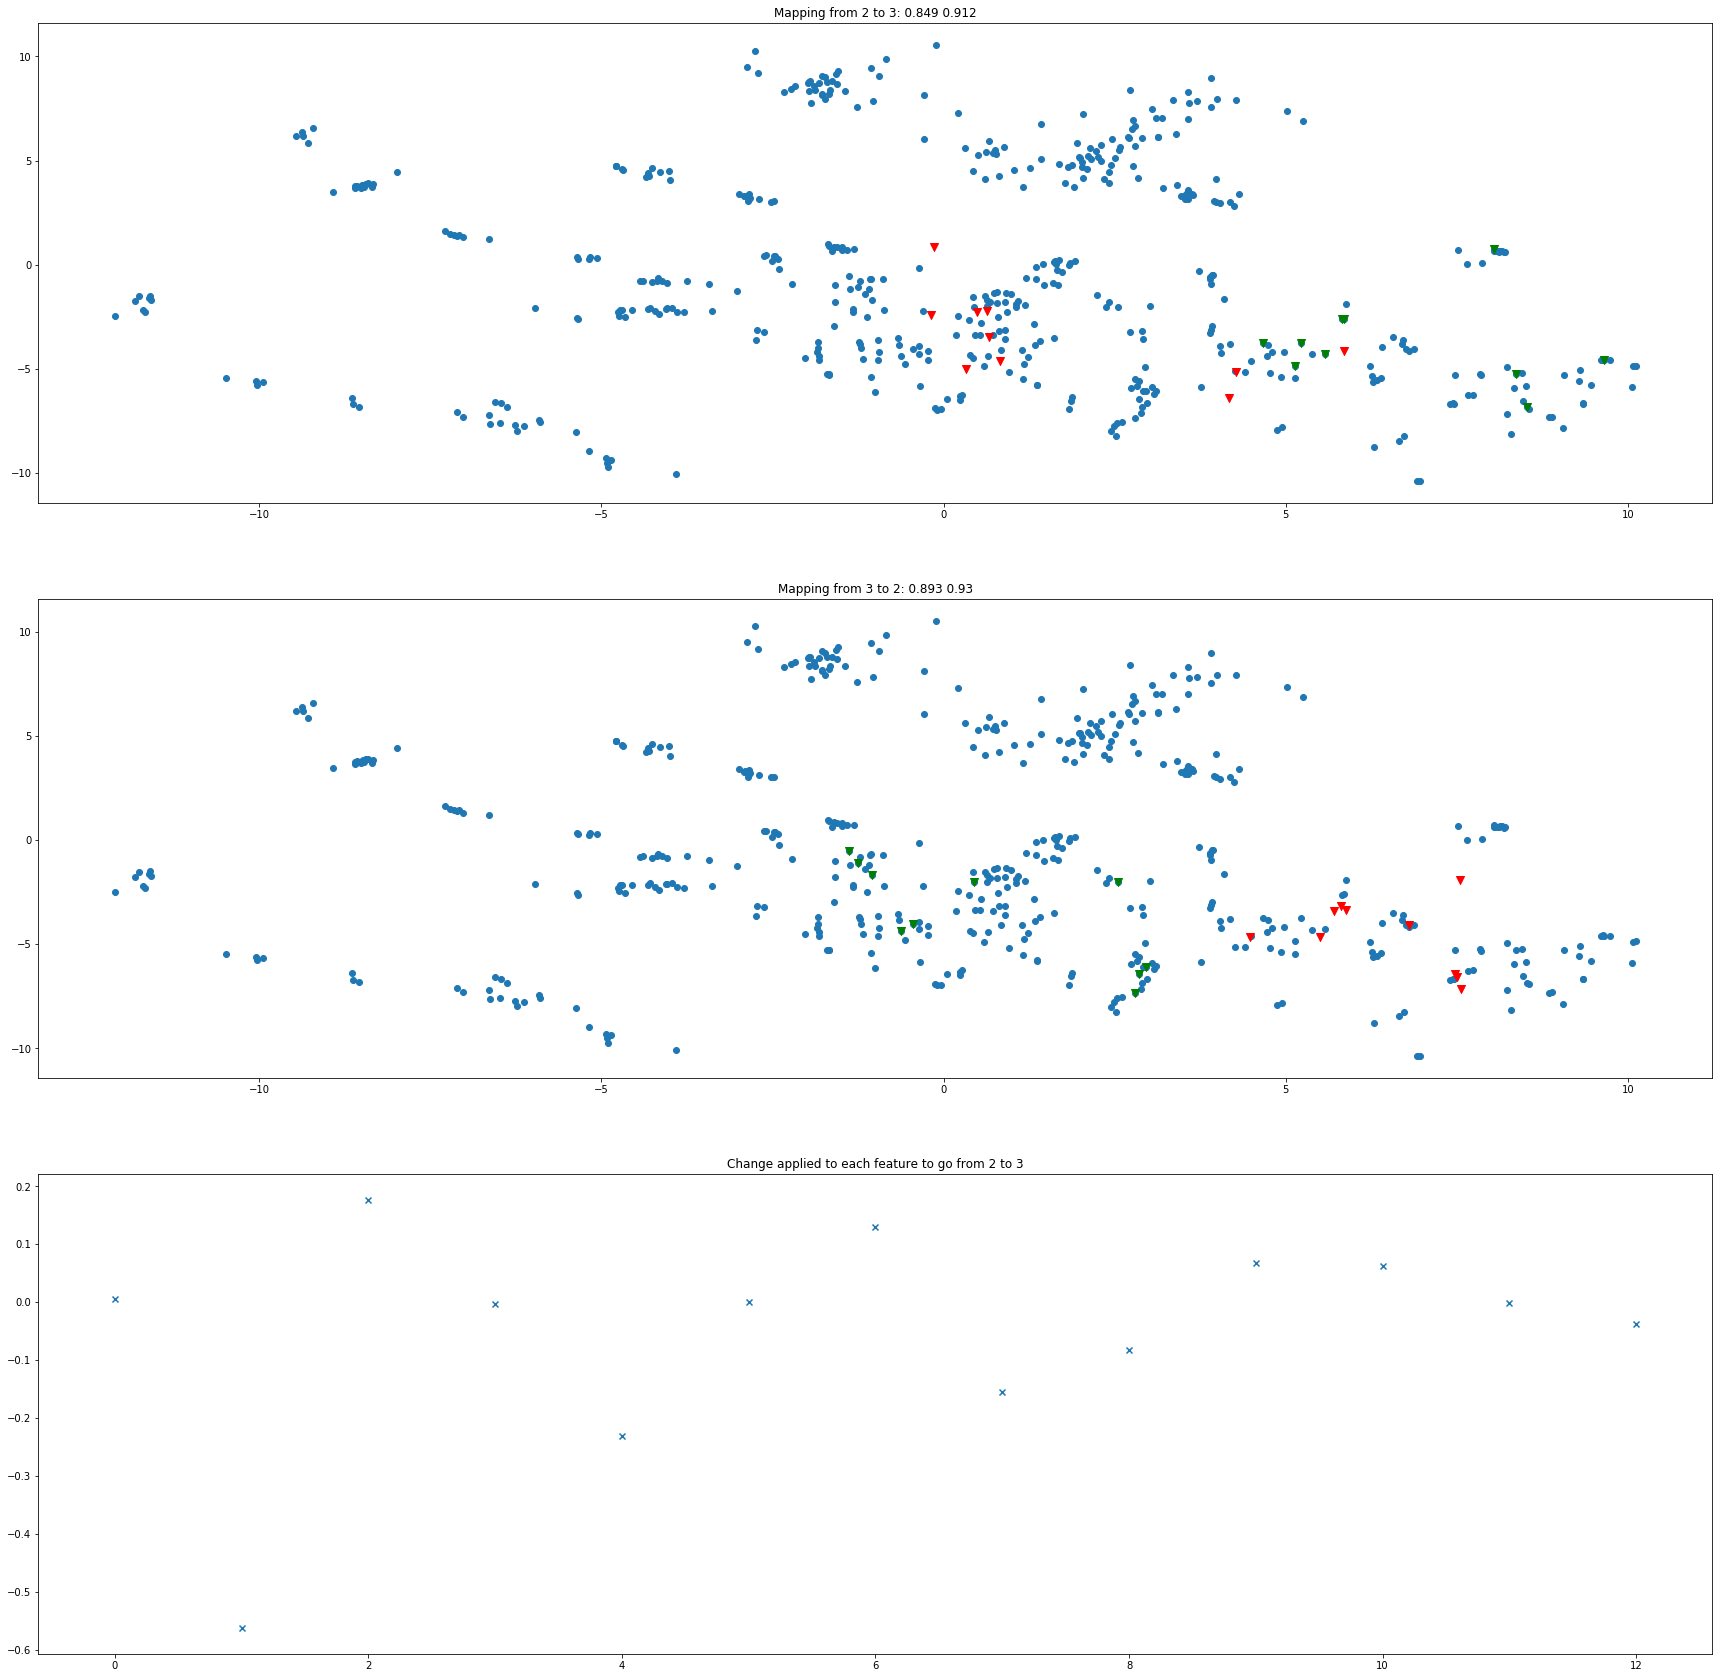

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


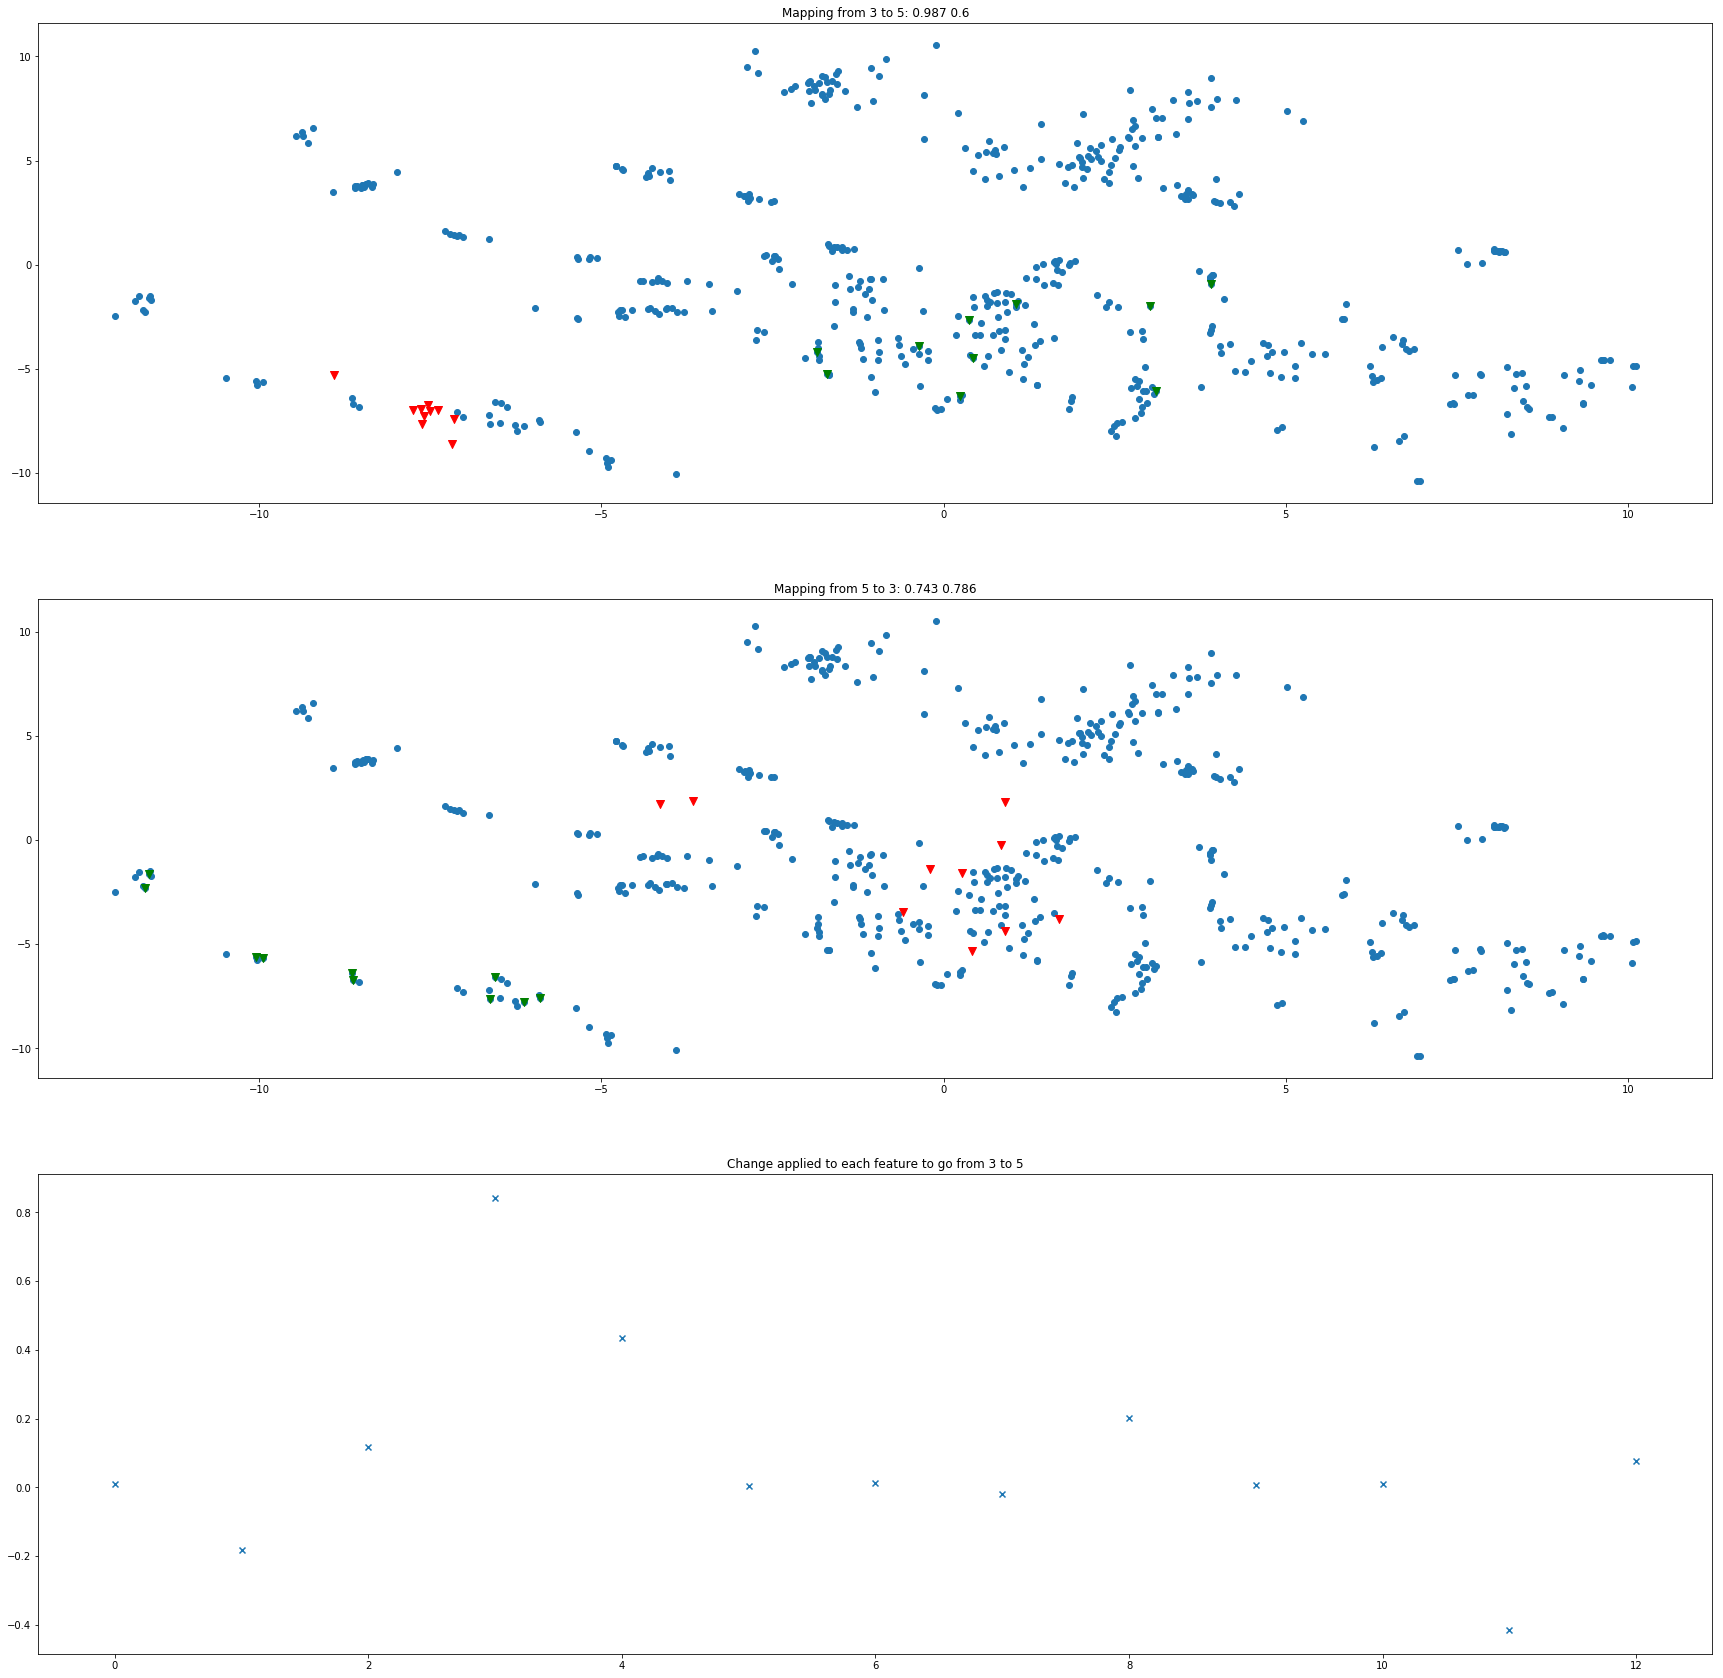

In [10]:
plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 1, 2, num_points = 10, name = "housing-1to2.png")

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 2, 3, num_points = 10, name = "housing-2to3.png")

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 3, 5, num_points = 10, name = "housing-3to5.png")

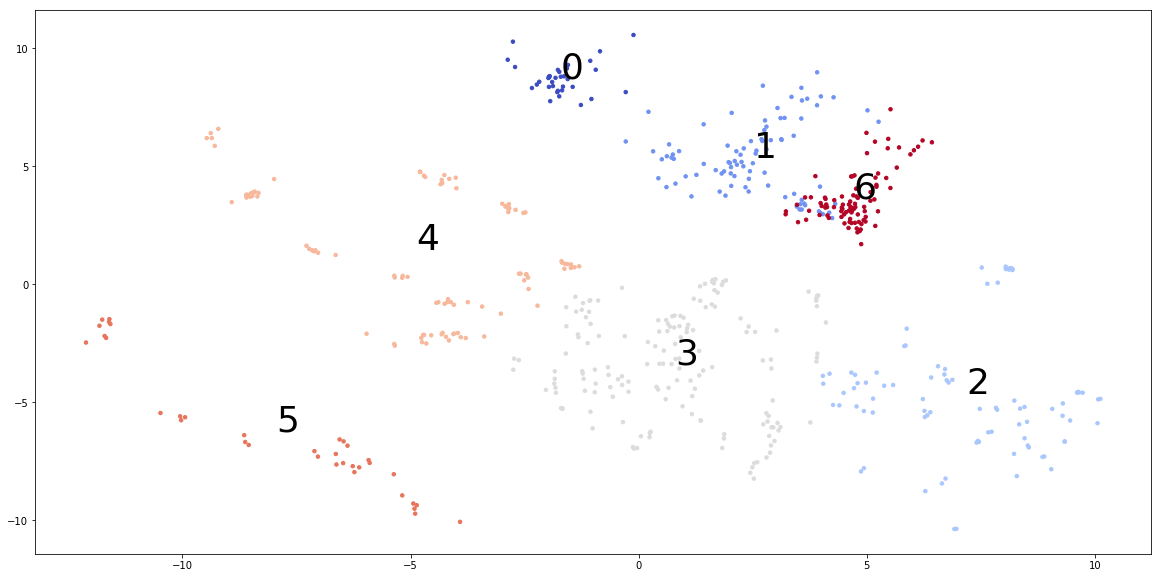

In [11]:
# Let's "corrupt" one of the groups

target_corrupted = 1

indices_corrupted = np.where(labels == target_corrupted)
n_corrupted = len(indices_corrupted[0])

x_corrupted = x[indices_corrupted]
x_corrupted[:, 6] -= 0.8 + np.random.uniform(low = -0.1, high = 0.1, size = n_corrupted)

x_full = np.vstack((x, x_corrupted))

labels_full = np.vstack((np.expand_dims(labels, 1), num_clusters * np.ones((n_corrupted,1))))

# Compute the new representation
data_rep_full = sess.run(rep, feed_dict={X: x_full, D: np.zeros((1, input_dim))})

# Visualize the clusters in the learned representation
means_full, centers_full, indices_full = plot_groups(x_full, data_rep_full, num_clusters + 1, labels_full, name = "housing-rep-corrupted.png")


In [12]:
# Compute the group explanations

best_val = 0.0
for i in range(5):
    deltas = explain(load_model, means_full, centers_full, learning_rate = 0.01, consecutive_steps = 5, lambda_global = 3.0)
    a, b = metrics(load_model, x_full, indices_full, deltas, epsilon)
    
    val = np.mean(a)
    
    if val > best_val:
        best_val = val
        np.save("deltas_corrupted.npy", deltas)
    
    os.system("rm -rf explanation")

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_l

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


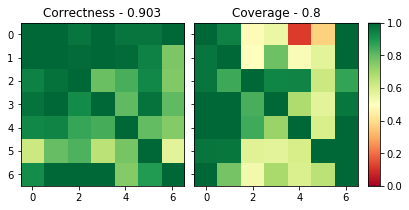

In [13]:
# Evaluate the explanations

deltas = np.load("deltas_corrupted.npy")

a, b = metrics(load_model, x_full, indices_full, deltas, epsilon)

plot_metrics(a, b, name = "housing-metrics-corrupted.png")

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


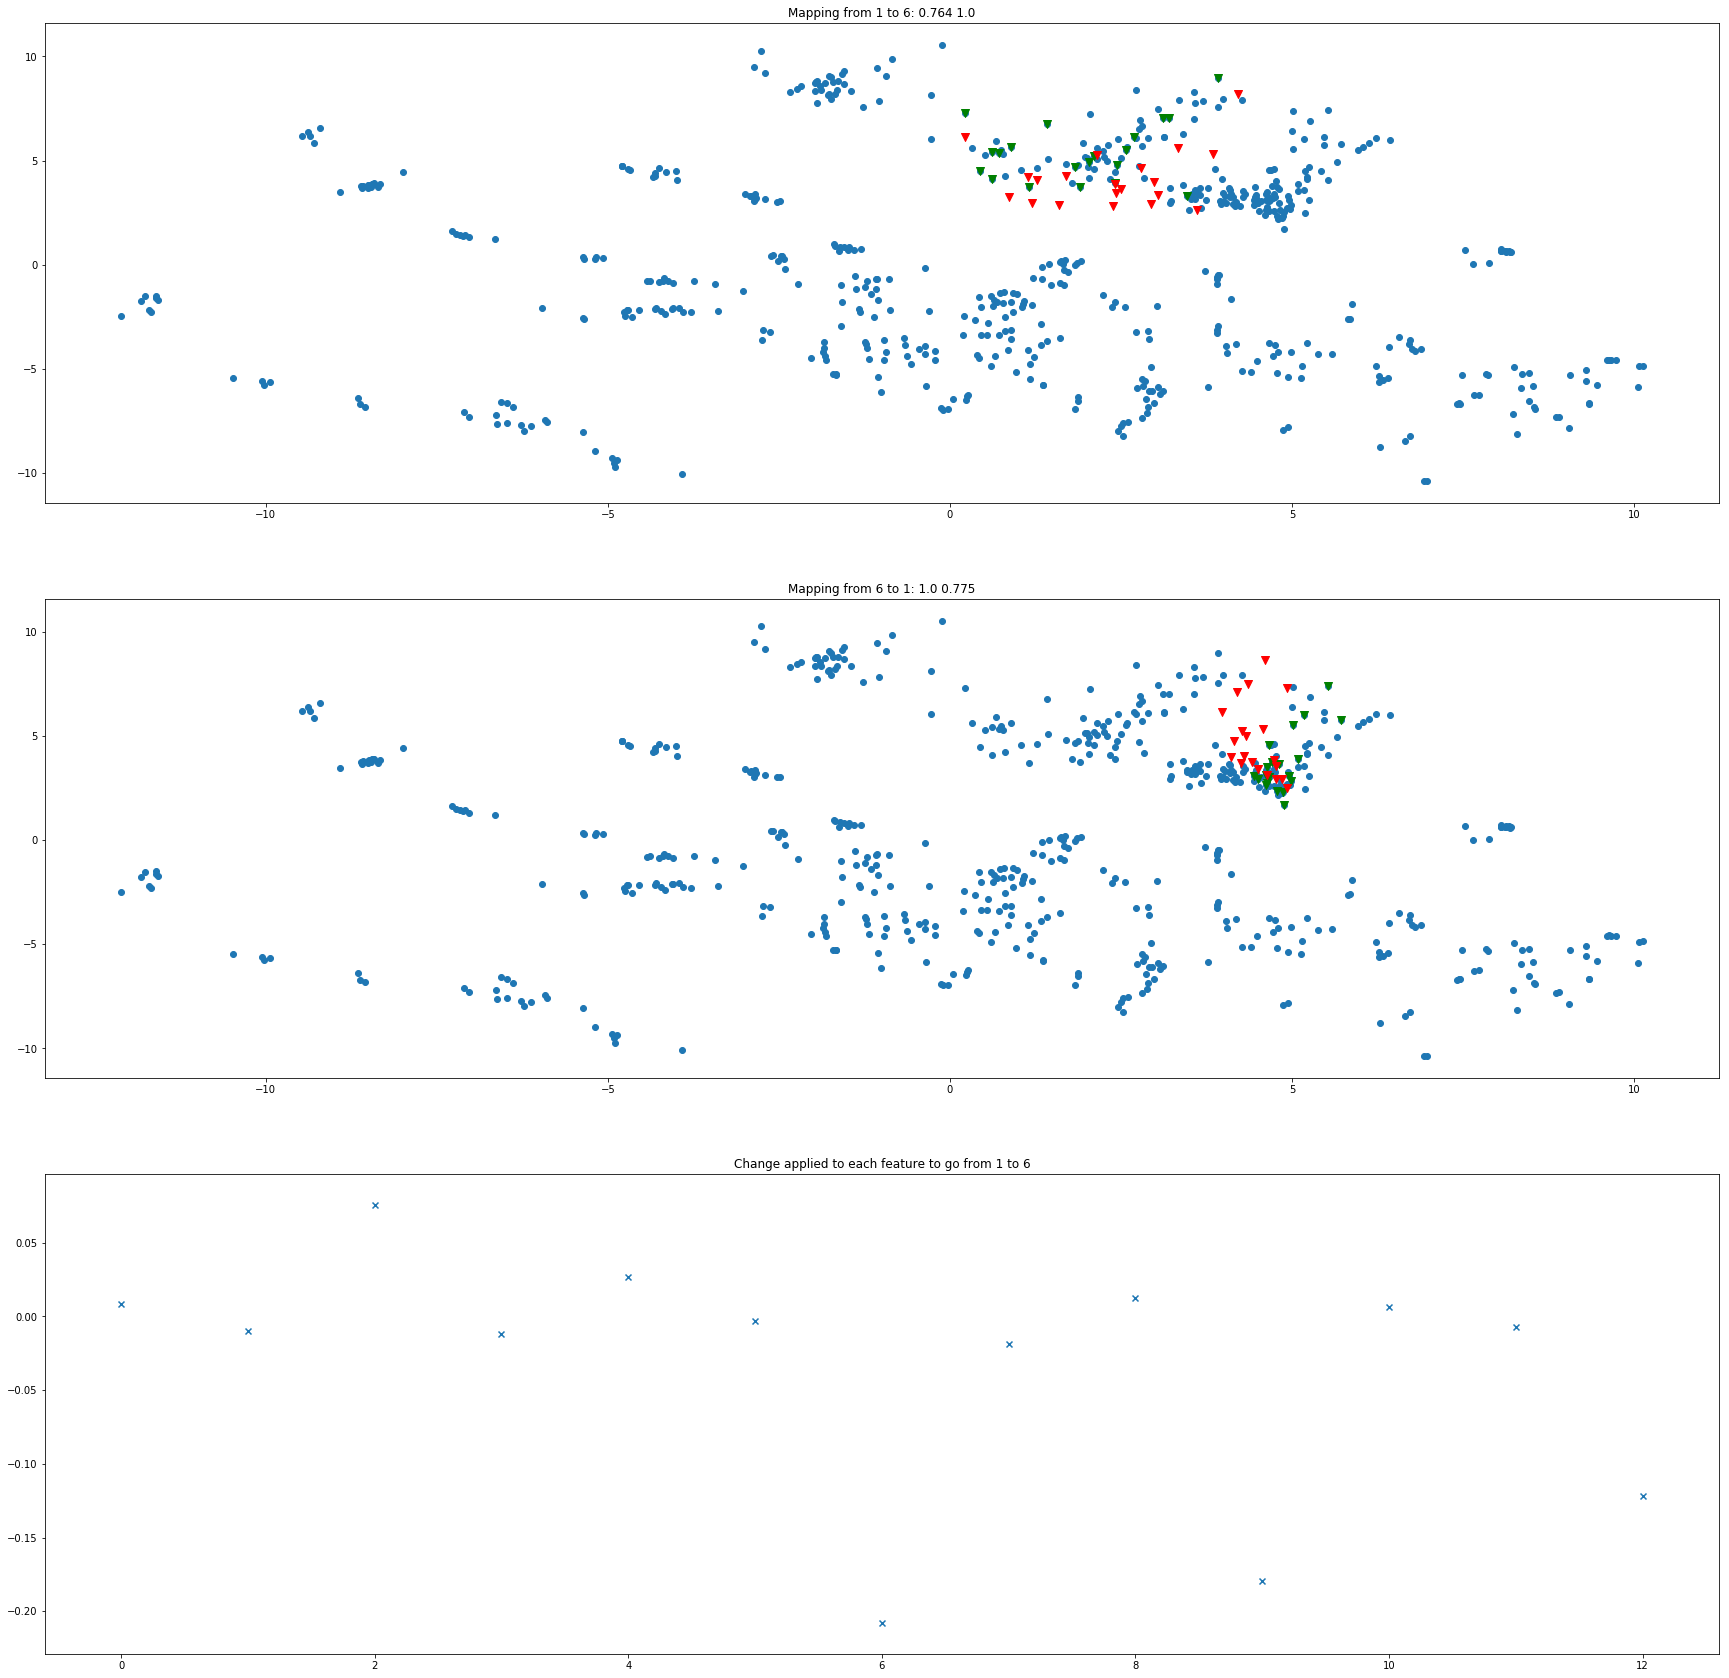

In [14]:
# Check if we found the corruption

plot_explanation(load_model, x_full, data_rep_full, indices_full, deltas, a, b, target_corrupted, num_clusters, name = "housing-t2c.png", num_points = 20)


[[ 0.01 -0.02 -0.21 -0.03 -0.02  0.01 -0.01 -0.04 -0.08  0.04 -0.02  0.7
   0.  ]
 [-0.01  0.81 -0.51 -0.02 -0.26  0.   -0.15  0.24 -0.69 -0.79 -0.1   1.12
  -0.38]
 [-0.    0.24 -0.33 -0.02 -0.49  0.   -0.02  0.09 -0.77 -0.72 -0.03  1.12
  -0.42]
 [-0.03 -0.01 -0.07 -0.06  0.   -0.02  0.02 -0.04 -0.84 -0.63  0.06  0.69
  -0.12]
 [ 0.01  0.06 -0.21  0.82 -0.06  0.01 -0.01  0.07 -0.57 -0.72 -0.02  0.71
  -0.35]]
[[ 0.01  0.   -0.17 -0.03 -0.01  0.   -0.08  0.01 -0.07 -0.02 -0.03  0.75
   0.01]
 [ 0.02  0.81 -0.52 -0.02 -0.27  0.   -0.25  0.23 -0.68 -0.8  -0.06  1.09
  -0.34]
 [-0.02  0.2  -0.27 -0.07 -0.44  0.   -0.08  0.1  -0.75 -0.84 -0.07  1.11
  -0.38]
 [-0.03  0.01 -0.1   0.02 -0.04 -0.   -0.01 -0.   -0.85 -0.56  0.    0.79
  -0.16]
 [ 0.   -0.02 -0.15  0.84 -0.01  0.   -0.04  0.03 -0.57 -0.7   0.02  0.69
  -0.27]]


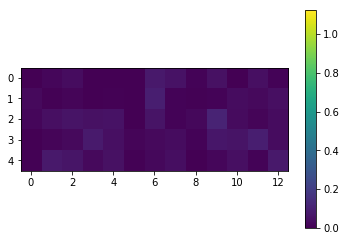

In [15]:
# Evaluate how much the other explanations changed

deltas_original = np.load("deltas.npy")

print(np.round(deltas_original, 2))
print(np.round(deltas[:num_clusters - 1, ], 2))

diff = np.abs(deltas_original - deltas[:num_clusters - 1, ])

import matplotlib.pyplot as plt

plt.imshow(diff, vmin = 0.0, vmax = np.max(np.abs(deltas_original)))
plt.colorbar()
plt.show()
plt.close()
